In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm


# defining a fit function using gaussian mixture
def fit(x, data, N):
    y = []
    gm = GaussianMixture(n_components=N, random_state=0).fit(data)
    # while evaluating gaussian mixture, also the aic value is saved in order to find the best model
    aic.append(gm.aic(data))
    for i in range(N):
        y.append(gm.weights_[i]*norm.pdf(x, gm.means_[i], np.sqrt(gm.covariances_[i][0])))
    return sum(y)

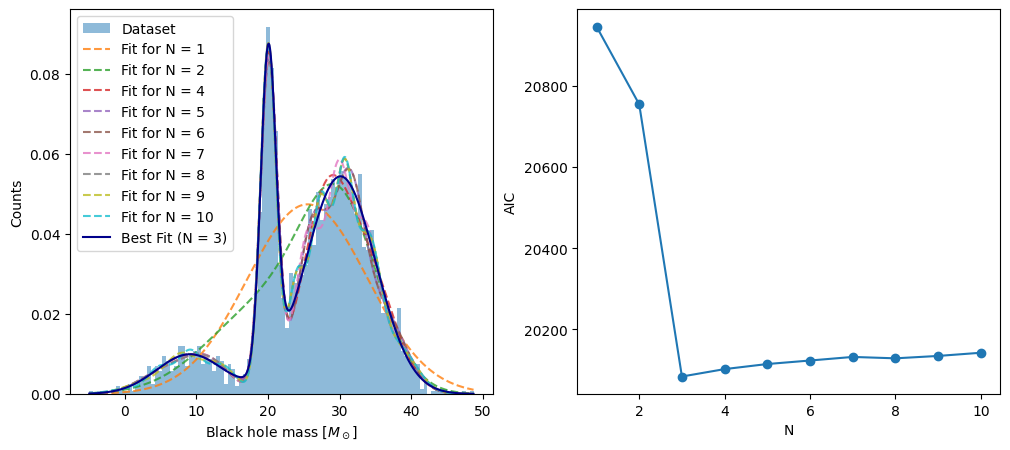

In [2]:
data=np.load('Datasets/formationchannels.npy')
fig,ax = plt.subplots(1,2,figsize=(12,5))

x = np.linspace(min(data), max(data), 1000)
Nbins = 100
ax[0].hist(data, bins=Nbins, density=True, alpha=0.5, label = 'Dataset')
aic=[]
# evaluating the GM fit for different numbers of gaussians
N=range(1,11)
for i in N:
    somma=fit(x, data, i)

ax[1].plot(range(1, 11), aic,marker='o',linestyle='-')
ax[1].set(xlabel='N',ylabel='AIC')
#finding the best model (the +1 is needed because of the indexing in N)
minimum = np.argsort(aic)[0]+1

# plotting the results, putting in evidence the best fit
for i in N:
    if i!=minimum:
        ax[0].plot(x, fit(x, data, i), alpha=0.8, linestyle='--', label = f'Fit for N = {i}')
ax[0].plot(x, fit(x, data, minimum), color = 'darkblue', label = f'Best Fit (N = {minimum})')
ax[0].set(xlabel=r'Black hole mass $[M_\odot]$',ylabel='Counts')
ax[0].legend()

[Text(0.5, 0, 'Black hole mass $[M_\\odot]$'), Text(0, 0.5, 'Counts')]

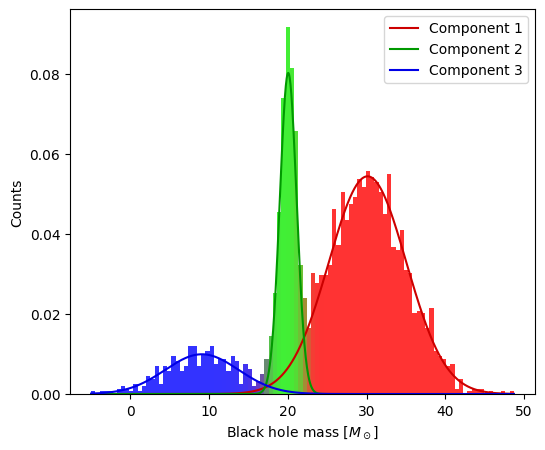

In [5]:
# trying to represent the probability that each event comes from a different channel
# this has be done considering that the best solution has 3 gaussian components and
# so using the mixing between RGB colors the probability that each bins com from one of the gaussians can be mapped
fig,ax = plt.subplots(1,1,figsize=(6,5))
gmm = GaussianMixture(n_components=minimum, random_state=0).fit(data)
counts, bin_edges = np.histogram(data, bins=100, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_centers_reshaped = bin_centers.reshape(-1, 1)

probs = gmm.predict_proba(bin_centers_reshaped)
colors = probs / probs.sum(axis=1, keepdims=True)
colors = np.clip(colors, 0, 1)
rgba_colors = np.zeros((colors.shape[0], 4))
rgba_colors[:, :3] = colors  # R, G, B
rgba_colors[:, 3] = 0.8      # Alpha

for i in range(len(bin_centers)):
    ax.bar(bin_centers[i], counts[i],
           width=(bin_edges[1] - bin_edges[0]),
           color=rgba_colors[i],
           align='center', edgecolor='none')

# in addition to the histogram with the color coding defined before,
# also the 3 different gaussians have been plotted separately
means = gmm.means_.flatten()
covariances = gmm.covariances_.flatten()
weights = gmm.weights_
curve_colors = [
    (0.8, 0, 0),    # dark red
    (0, 0.6, 0),    # dark green
    (0, 0, 0.9)     # dark blue
]
for i in range(gmm.n_components):
    mean = means[i]
    std = np.sqrt(covariances[i])
    weight = weights[i]
    ax.plot(x, weight*norm(loc=mean,scale=std).pdf(x), label=f'Component {i+1}',
            color=curve_colors[i])

x_plot = np.linspace(data.min() - 1, data.max() + 1, 1000).reshape(-1, 1)
logprob = gmm.score_samples(x_plot)
pdf = np.exp(logprob)

ax.legend()
ax.set(xlabel=r'Black hole mass $[M_\odot]$',ylabel='Counts')